In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy.linalg as linalg
from jax import grad, value_and_grad, lax
import matplotlib.pyplot as plt
import optax
import jax.random as random

In [ ]:
# number of spatial elements
n_h = 150
h = 1.0 / n_h
n_k = 50   # time steps
k = 0.5 / n_k
n = (n_h-1) * n_k

_t = jnp.linspace(0, 0.5, n_k+1)
_x = jnp.linspace(0, 1, n_h+1)

In [ ]:
def true_initcond_force(conds_case='osc'):
  if conds_case == 'osc':
    # initial condition
    u0_true = jnp.sin(jnp.pi * _x[1:-1]).reshape(1, n_h-1, 1)
    # forcing term f(t, x)
    f_true = jnp.stack([
      (jnp.pi**2 * jnp.cos(jnp.pi * tq) - jnp.pi * jnp.sin(jnp.pi * tq))
      * jnp.sin(jnp.pi * _x[1:-1])
      for tq in _t[1:]
    ]).reshape(n_k, 1, n_h-1, 1)

  elif conds_case == 'dec':
    # initial condition
    u0_true = jnp.sin(jnp.pi * _x[1:-1]).reshape(1, n_h-1, 1)
    # forcing term f(t, x)
    f_true = jnp.stack([
      (jnp.pi**2 - 1.0) * jnp.exp(-tq) * jnp.sin(jnp.pi * _x[1:-1])
      for tq in _t[1:]
    ]).reshape(n_k, 1, n_h-1, 1)

  elif conds_case == 'sin_sin':
    # initial condition
    u0_true = jnp.zeros((1, n_h-1, 1))
    # forcing term f(t, x)
    f_true = jnp.stack([
      jnp.pi * jnp.cos(jnp.pi * tq) + (jnp.pi**2) * jnp.sin(jnp.pi * tq) * jnp.sin(jnp.pi * _x[1:-1])
      for tq in _t[1:]
    ]).reshape(n_k, 1, n_h-1, 1)


  return u0_true, f_true


u0_true, f_true = true_initcond_force('osc')


In [ ]:
def heat_solver_matrix():
    diag = jnp.zeros((n_h-1, n_h-1))
    diag = diag.at[jnp.arange(n_h-1), jnp.arange(n_h-1)].set(1./k + 2.0/h**2)
    diag = diag.at[jnp.arange(n_h-2), jnp.arange(1, n_h-1)].set(-1.0/h**2)
    diag = diag.at[jnp.arange(1, n_h-1), jnp.arange(n_h-2)].set(-1.0/h**2)
    return diag

A_k = heat_solver_matrix()
# Factorize A_k = L L^T
L = jnp.linalg.cholesky(A_k)  # (149,149)

In [ ]:
@jax.jit
def step(u, f_t, L, k):
    """Backward Euler step using Cholesky factorization:
       solve A u_{n+1} = f + (1/k) u_n"""
    u = u.reshape(-1)
    f_t = f_t.reshape(-1)
    rhs = f_t + (1.0 / k) * u
    y = jax.scipy.linalg.solve_triangular(L, rhs, lower=True)
    u_next = jax.scipy.linalg.solve_triangular(L.T, y, lower=False)

    return u_next


@jax.jit
def time_stepping(u0, f, L, k):
    u0 = u0.reshape(-1)   # (149,)
    def body_fn(u_prev, f_t):
        u_next = step(u_prev, f_t, L, k)    # (149,)
        return u_next, u_next         # carry, output both (149,)
    _, us = jax.lax.scan(body_fn, u0, f)  # us: (n_k,149)
    return jnp.vstack([u0[None, :], us])  # (n_k+1,149)



u_traj_true = time_stepping(u0_true, f_true, L, k)


reg_alpha = 1e-5
reg_smooth_1st = 1e-3  # First derivative (gradient)
reg_smooth_2nd = 1e-3  # Second derivative (curvature)
reg_smooth_cross = 1e-3  # Cross derivatives (mixed partials)

@jax.jit
def loss_fn(f, u0_true, u_traj_true, L, k, n_h, n_k):
    u_traj_guess = time_stepping(u0_true, f, L, k)

    mse = jnp.linalg.norm(u_traj_guess-u_traj_true)

    # L2 regularization
    reg = jnp.linalg.norm(f)

    # 1st order smoothness (both directions, all columns)
    smooth_1st_x = jnp.linalg.norm(f[1:, :] - f[:-1, :])
    smooth_1st_t = jnp.linalg.norm(f[:, 1:] - f[:, :-1])

    # 2nd order smoothness (penalizes curvature/acceleration)
    smooth_2nd_x = jnp.linalg.norm(f[2:, :] - 2*f[1:-1, :] + f[:-2, :])
    smooth_2nd_t = jnp.linalg.norm(f[:, 2:] - 2*f[:, 1:-1] + f[:, :-2])

    smooth_2nd_xt = jnp.linalg.norm(f[1:, 1:] - f[1:, :-1] - f[:-1, 1:] + f[:-1, :-1])

    total_loss = mse + \
            reg_alpha * reg + \
            reg_smooth_1st * (smooth_1st_x + smooth_1st_t) + \
            reg_smooth_2nd * (smooth_2nd_x + smooth_2nd_t) + \
            reg_smooth_cross * smooth_2nd_xt \

    # aux_info = dict(mse_loss=mse, smooth_1st=smooth_1st_x + smooth_1st_t, smooth_2nd=smooth_2nd_x + smooth_2nd_t, smooth_cross=smooth_2nd_xt)

    return total_loss

In [ ]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive/')
f_presaved = jnp.array(np.load("/content/drive/My Drive/f_sinsin_learned.npy"))
f_presaved.shape

Mounted at /content/drive/


(50, 1, 149, 1)

In [ ]:
def train_ada(num_epochs=15000, lr=20):
    # Initialize parameter
    key = random.PRNGKey(0)  # set seed for reproducibility
    f_guess = random.normal(key, shape=f_true.shape)
    # f_guess=f_learned
    # Setup Adagrad optimizer
    opt = optax.adagrad(lr)
    opt_state = opt.init(f_guess)

    losses = []

    for epoch in range(num_epochs):
        loss, grad = \
         value_and_grad(loss_fn)(f_guess, u0_true, u_traj_true, L, k, n_h, n_k)

        # Update step
        updates, opt_state = opt.update(grad, opt_state)
        f_guess = optax.apply_updates(f_guess, updates)

        losses.append(float(loss))

        if epoch % 500 == 0:
            print(f"Epoch {epoch} , Loss = {loss:.9f}")
            # print(f"Epoch {epoch}, Loss = {loss:.6f}, MSE = {aux_info.mse_loss:.6f}, smooth_1st = {aux_info.smooth_1st:.6f}, smooth_2nd = {aux_info.smooth_1st:.6f}, smooth_cross = {aux_info.smooth_2nd_xt:.6f}")

    return f_guess, losses

f_learned, losses = train_ada()

Epoch 0 , Loss = 29.085790634
Epoch 500 , Loss = 0.298611879
Epoch 1000 , Loss = 0.326408297
Epoch 1500 , Loss = 0.361226380
Epoch 2000 , Loss = 0.390687287
Epoch 2500 , Loss = 0.412412435
Epoch 3000 , Loss = 0.426125318
Epoch 3500 , Loss = 0.434547395
Epoch 4000 , Loss = 0.431869507
Epoch 4500 , Loss = 0.428917170
Epoch 5000 , Loss = 0.427305609
Epoch 5500 , Loss = 0.424598873
Epoch 6000 , Loss = 0.423177361
Epoch 6500 , Loss = 0.421185911
Epoch 7000 , Loss = 0.419541717
Epoch 7500 , Loss = 0.418043077
Epoch 8000 , Loss = 0.416278690
Epoch 8500 , Loss = 0.414663672
Epoch 9000 , Loss = 0.413179457
Epoch 9500 , Loss = 0.411550134
Epoch 10000 , Loss = 0.410006851
Epoch 10500 , Loss = 0.408410847
Epoch 11000 , Loss = 0.406827629
Epoch 11500 , Loss = 0.405503243
Epoch 12000 , Loss = 0.403951973
Epoch 12500 , Loss = 0.402364701
Epoch 13000 , Loss = 0.401089132
Epoch 13500 , Loss = 0.399737388
Epoch 14000 , Loss = 0.398226142
Epoch 14500 , Loss = 0.397101849


In [ ]:
f_store = f_learned

In [ ]:
np.save("/content/drive/My Drive/f_sinsin_learned.npy", np.array(f_learned))

Mounted at /content/drive/


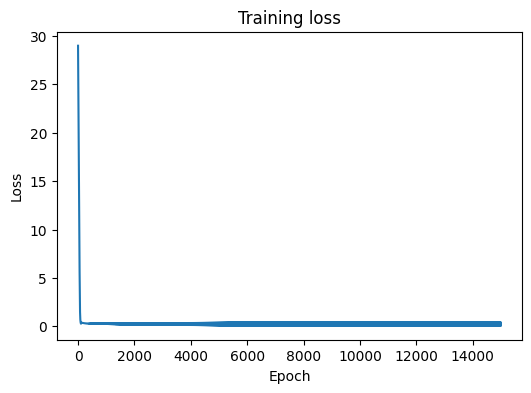

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()


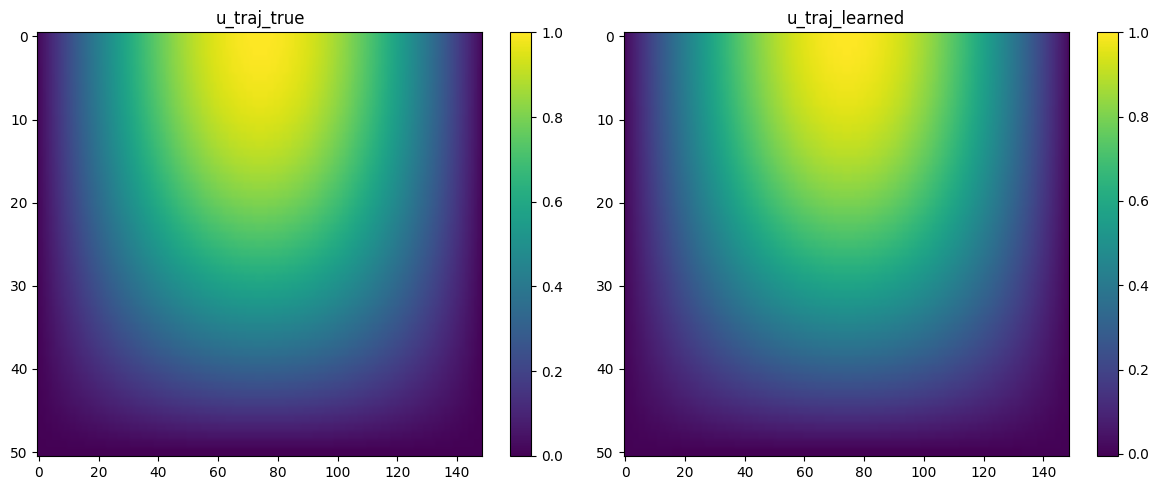

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot matrix A
im1 = axes[0].imshow(u_traj_true, aspect='auto', cmap='viridis')
axes[0].set_title('u_traj_true')
fig.colorbar(im1, ax=axes[0])

# Plot matrix B
u_traj_learned = time_stepping(u0_true, f_learned, L, k)
im2 = axes[1].imshow(u_traj_learned, aspect='auto', cmap='viridis')
axes[1].set_title('u_traj_learned')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

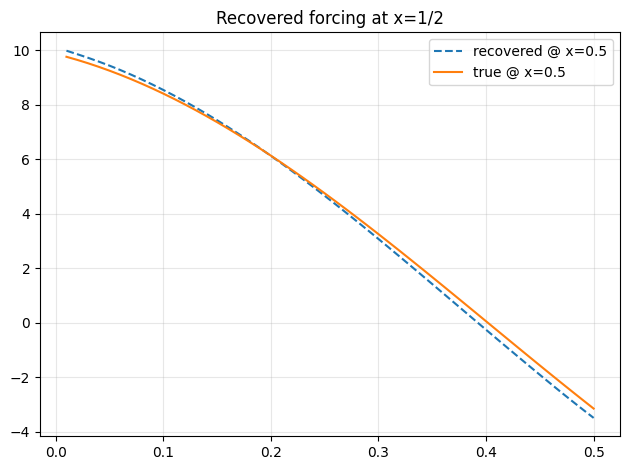

In [ ]:
at_x = int(n_h/2)

plt.plot(_t[1:], f_learned.reshape(n_k, n_h-1)[:, at_x], '--', label='recovered @ x=0.5')
plt.plot(_t[1:], f_true.reshape(n_k, n_h-1)[:,at_x], label='true @ x=0.5')
plt.legend(); plt.grid(True, alpha=0.3); plt.title("Recovered forcing at x=1/2")


plt.tight_layout(); plt.show()

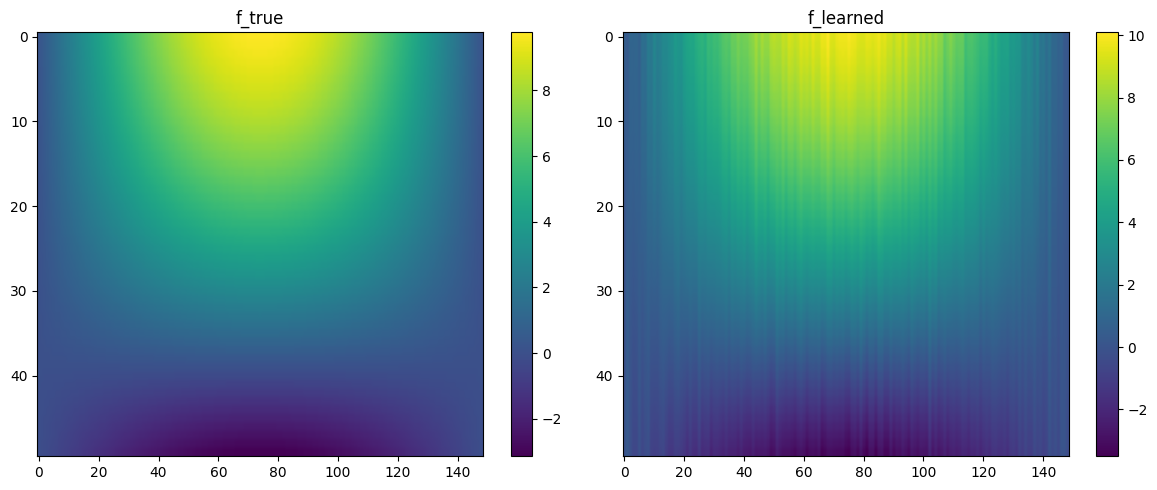

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns


# Plot matrix A
im1 = axes[0].imshow(f_true.reshape(n_k, n_h-1), aspect='auto', cmap='viridis')
axes[0].set_title('f_true')
fig.colorbar(im1, ax=axes[0])

# Plot matrix B
im2 = axes[1].imshow(f_learned.reshape(n_k, n_h-1), aspect='auto', cmap='viridis')
axes[1].set_title('f_learned')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()